# Plot

> A collection of plot functions

In [1]:
#| default_exp plot

In [2]:
#| hide
import sys
sys.path.append('/notebooks/katlas')
from nbdev.showdoc import *
%matplotlib inline

In [3]:
#| export
from katlas.feature import *
from katlas.core import Data
from fastbook import *
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
import joblib
from adjustText import adjust_text
from pathlib import Path

/usr/local/lib/python3.9/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [4]:
#| export
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

In [5]:
#| export
def reduce_dim(df, 
               method='pca', 
               n_components=2, 
               complexity = 20, # umap default: 15, tsne default: 30
               load=None, # load a previous model
               save=None, # pkl file to be saved, e.g. pca_model.pkl
               seed =123):
    
    "Reduce dim except first column"
    if load is not None:
        reducer = joblib.load(load)
    else:
        if method == 'pca':
            reducer = PCA(n_components=n_components, random_state=seed)
        elif method == 'tsne':
            reducer = TSNE(n_components=n_components,
                           random_state=seed, 
                           perplexity = complexity # default from official is 30 
                          )
        elif method == 'umap':
            reducer = UMAP(n_components=n_components, 
                           random_state=seed, 
                           n_neighbors=complexity # default from official is 15, try 15-200
                          )
        else:
            raise ValueError('Invalid method specified')

    proj = reducer.fit_transform(df.iloc[:, 1:].values)
    embedding_df = pd.DataFrame(proj, columns=[f"{method.upper()}{i}" for i in range(1, n_components + 1)])
    embedding_df = pd.concat([df[df.columns[0]], embedding_df], axis=1)

    if save is not None:
        path = Path(save)
        path.parent.mkdir(exist_ok=True)
        
        joblib.dump(reducer, save)

    return embedding_df

In [6]:
#| export
def plot_cluster(df, 
                 method='pca', 
                 hue=None,
                 complexity = 30,
                 palette='tab20', 
                 legend=False, 
                 name_list=None, # a list or df Series of names that label the dots
                 seed = 123
                ):
    embedding_df = reduce_dim(df, method=method, seed=seed, complexity = complexity)
    x_col, y_col = [col for col in embedding_df.columns if col.startswith(method.upper())]
    sns.relplot(data=embedding_df, x=x_col, y=y_col, hue=hue, palette=palette, s=50, alpha=0.8, legend=legend)
    plt.xticks([])
    plt.yticks([])
    if name_list is not None:
        texts = [plt.text(embedding_df[f'{method.upper()}1'][i], embedding_df[f'{method.upper()}2'][i], name_list[i],fontsize=8) for i in range(len(embedding_df))]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    plt.show()
    plt.close()

In [7]:
df = Data.get_aa_feature()

In [8]:
info=Data.get_aa_info()

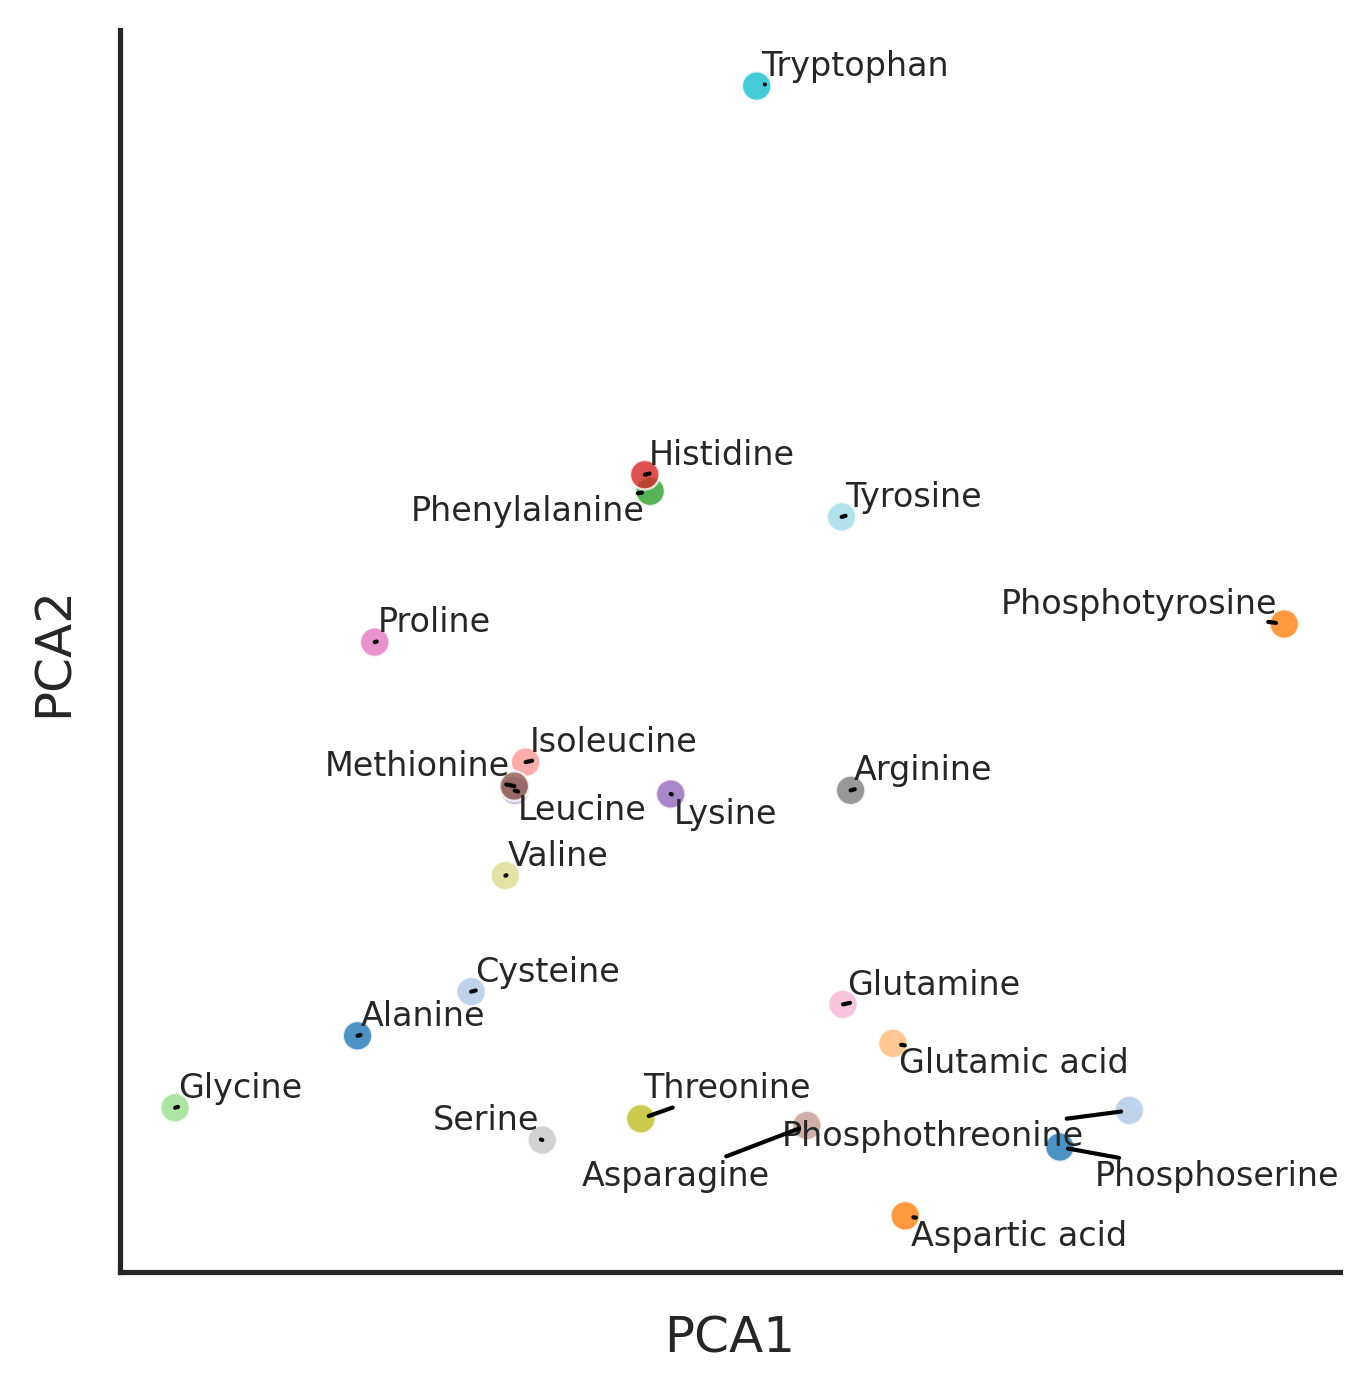

In [9]:
plot_cluster(df, name_list = info.Name,hue='aa')

If not removing highly correlated features

In [10]:
df = info[['aa','SMILES']]

In [11]:
full_feature = smi2prop(df, id_colname='aa',remove_duplicate=False)

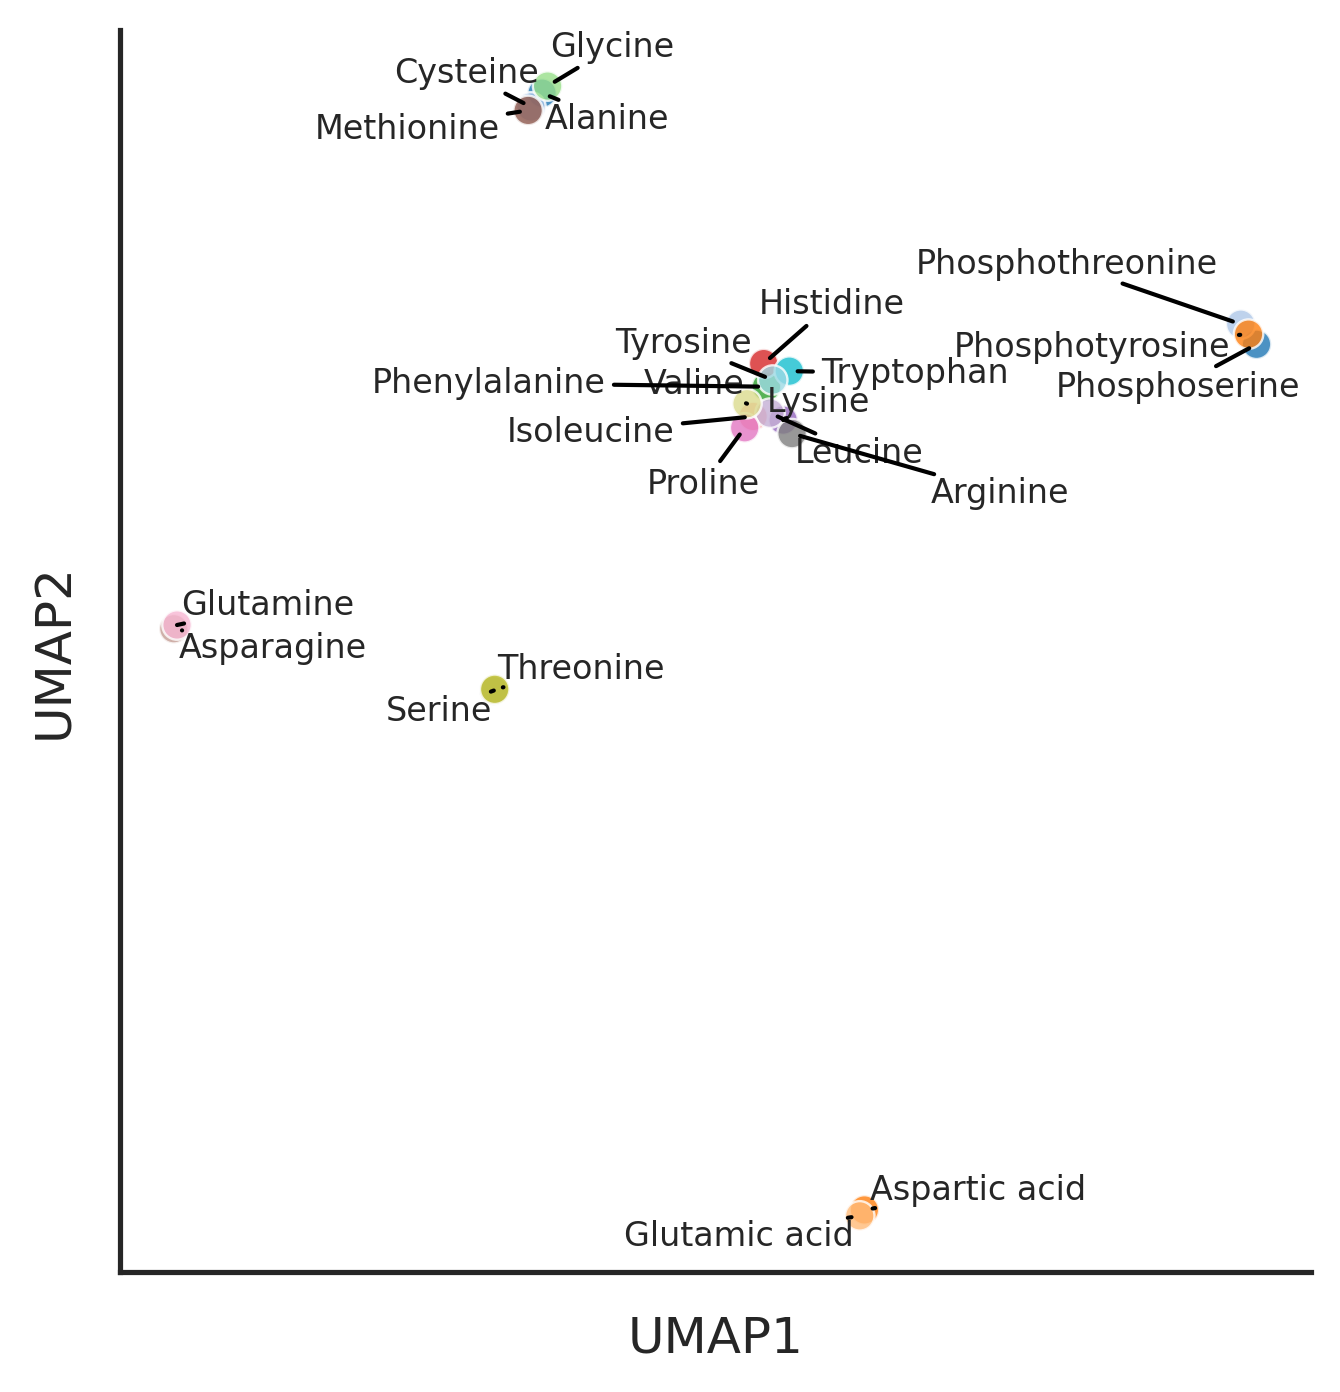

In [12]:
plot_cluster(full_feature, 'umap',complexity=2,name_list = info.Name,hue='aa')

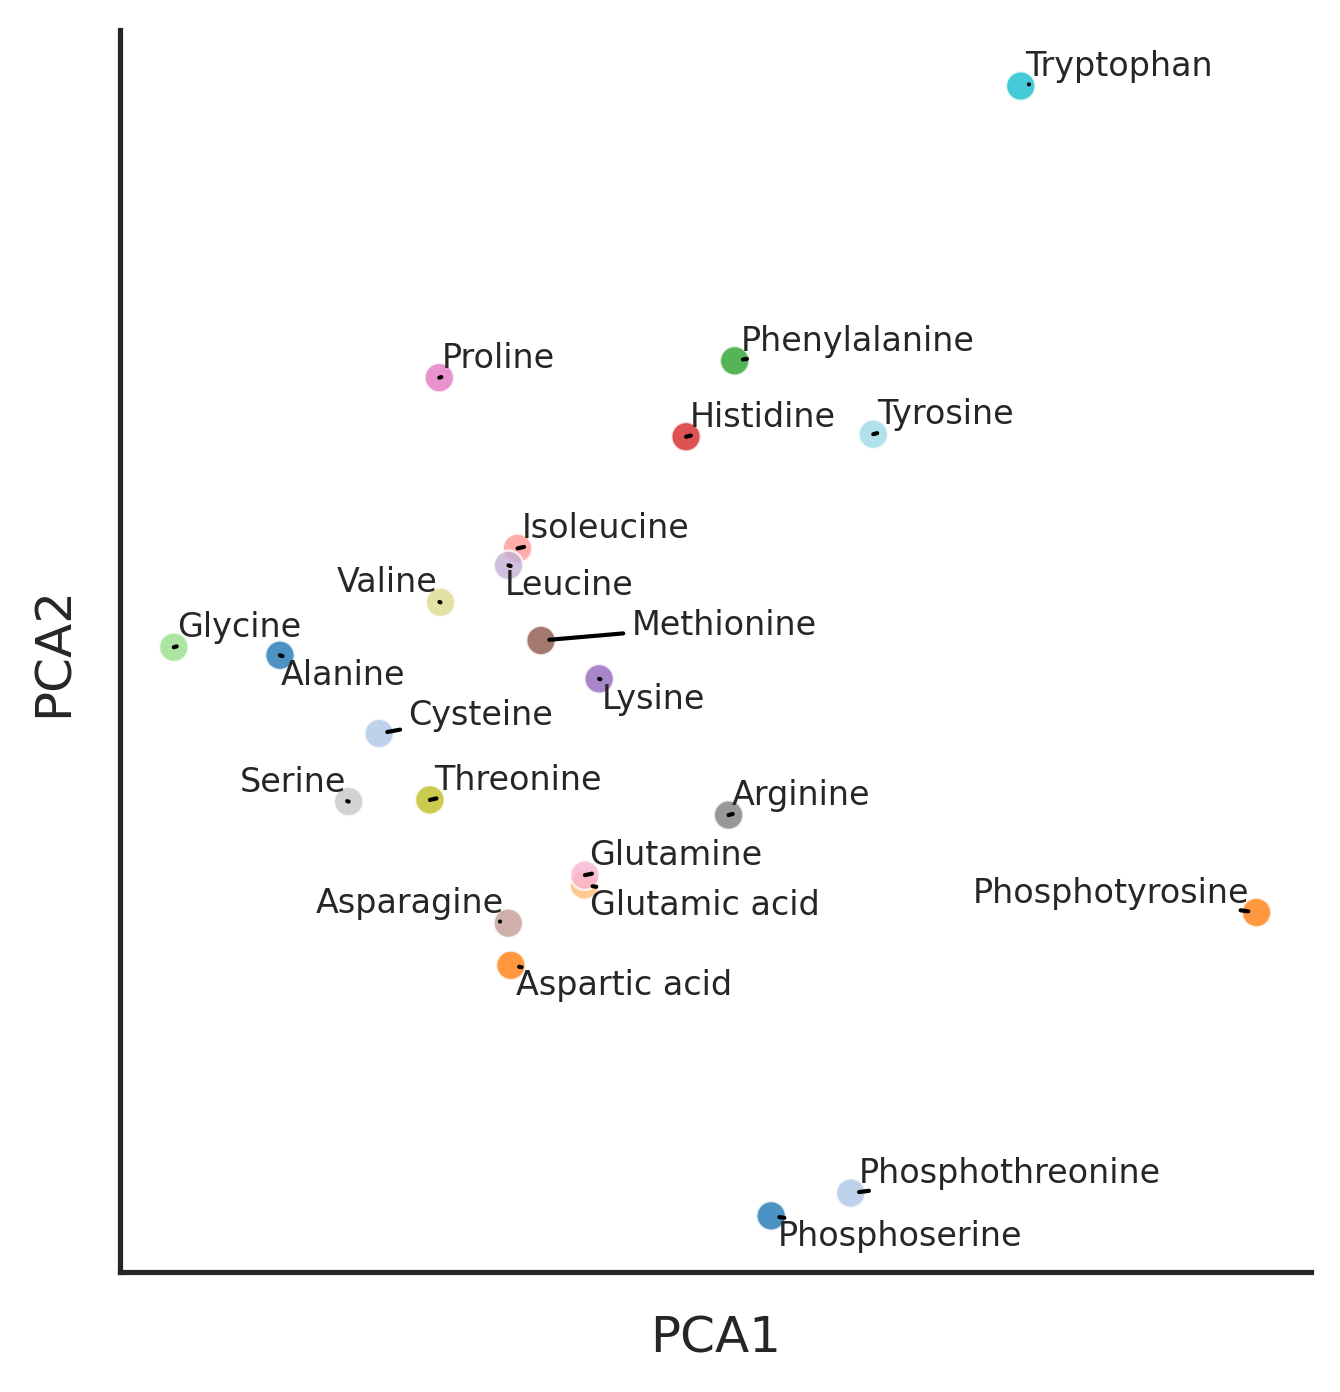

In [13]:
plot_cluster(full_feature, name_list = info.Name,hue='aa')

In [14]:
#| export
def plot_bar(data, 
             value_col, # colname of values
             groupby_col, # colname of categories which is used to groupby values
             circle = True,
             aspect = 3 # the biger, the wider
              ):
    
    order = data.groupby(groupby_col)[value_col].mean().sort_values(ascending=False).index
    g = sns.catplot(data=data,
                x=groupby_col,
                y=value_col,
                aspect=aspect,
                order=order,
                kind='bar',
                ci='sd',
                palette='tab20',)
    g.set_xticklabels(rotation=45)
    
    if circle:
        marker = {'marker': 'o', 
                  'color': 'white', 
                  'edgecolor': 'black', 
                  'linewidth': 1.5, 
                  's': 6}

        sns.stripplot(data=data, 
                      x=groupby_col, 
                      y=value_col,
                      order=order,
                      alpha=0.8,
                      ax=g.ax,
                      **marker);

In [15]:
df = Data.get_log_unstack()

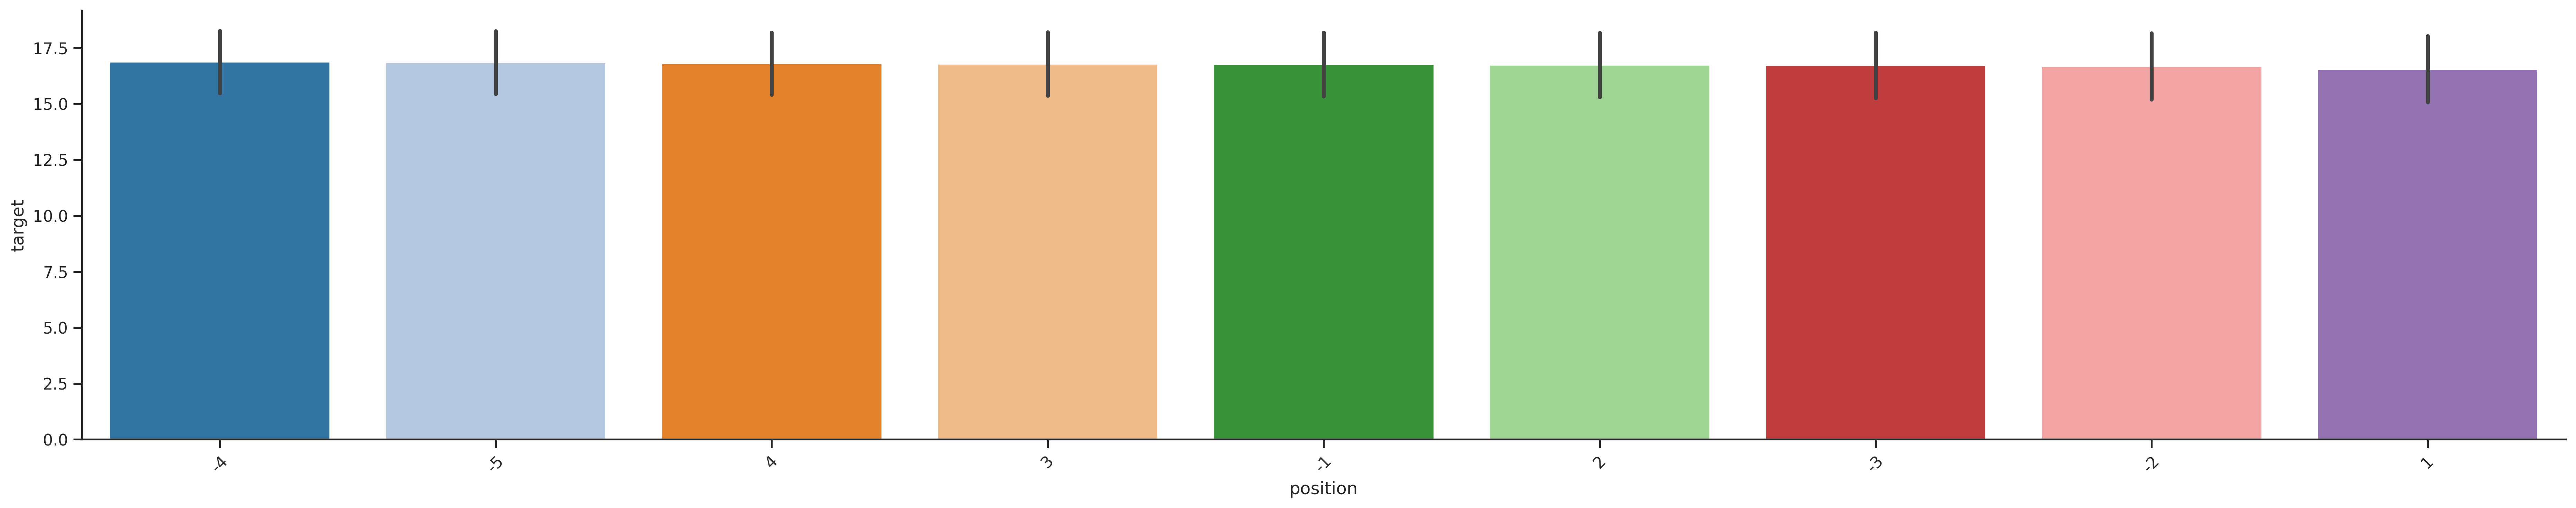

In [16]:
plot_bar(df,'target','position',circle=False,aspect=5)

In [17]:
#| export
def plot_corr(x,#a column of df
              y,#a column of df
              xlabel=None,# x axis label
              ylabel=None,# y axis label
              order=1, # polynomial level, if straight, order=1
              method = 'pearson'
             ):
    if method == 'spearman':
        correlation, pvalue = spearmanr(x, y)
    elif method == 'pearson':
        correlation, pvalue = pearsonr(x, y)
    else:
        raise ValueError("Invalid correlation method. Choose 'spearman' or 'pearson'.")
        
    sns.regplot(x=x,
            y=y,
            order=order,
            line_kws={'color': 'gray'}
           )
    
    if xlabel is not None:
        plt.xlabel(xlabel)
        
    if ylabel is not None:
        plt.ylabel(ylabel)
    
    correlation_text = f'Spearman: {correlation:.2f}' if method == 'spearman' else f'Pearson: {correlation:.2f}'

    plt.text(x=0.8, y=0.1, s=correlation_text, transform=plt.gca().transAxes, ha='center', va='center')
    
    plt.show()
    plt.close()

In [18]:
norm = Data.get_kinase_norm().set_index('kinase')

In [19]:
norm.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,0.0720,0.0245,0.0284,0.0456,0.0425,0.0425,0.0951,0.1554,0.0993,0.0864,0.0425,0.0952,0.0315,0.0331,0.0262,0.0956,0.056,0.0275,0.0160,0.0153,0.0201,0.0201,0.0611,0.0534,0.0642,0.0706,0.0560,0.0619,0.0619,0.0619,0.0621,0.0742,0.0693,0.0520,0.0534,0.0403,0.0514,0.0809,0.0715,0.0627,0.0429,0.0332,0.0560,0.0332,0.0332,0.0339,0.1084,0.0512,0.1119,0.0655,0.0527,0.0527,0.0641,0.0599,0.0527,0.0782,0.0487,0.0411,0.0425,0.0397,0.0517,0.0581,0.0695,0.0582,0.0272,0.0370,0.0303,0.0303,0.0274,0.0226,0.0283,0.0538,0.0588,0.0555,0.0555,0.0340,0.0378,0.0569,0.1166,0.0336,0.0399,0.0289,0.0567,0.0587,0.0555,0.1517,0.0808,0.0805,0.0636,0.0209,0.0209,0.0486,0.1136,0.0706,0.0385,0.0313,0.0545,0.0545,0.0392,0.0435,0.0654,0.0554,0.0545,0.0777,0.0440,0.0688,0.1229,0.0923,0.0397,0.0434,0.0161,0.0146,0.0121,0.0121,0.0178,0.0463,0.7216,0.0312,0.0223,0.0143,0.0143,0.0107,0.0102,0.0131,0.0124,0.0129,0.0143,0.0162,0.0160,0.0194,0.0249,0.0138,0.0170,0.0103,0.0098,0.0123,0.0123,0.0100,0.0527,0.0749,0.075,0.0684,0.0552,0.0552,0.0542,0.0370,0.0414,0.0481,0.0486,0.0459,0.0572,0.062,0.0577,0.0774,0.0771,0.0834,0.0552,0.0524,0.0409,0.0409,0.0410,0.0681,0.0923,0.0582,0.0742,0.0582,0.0582,0.0610,0.0388,0.0489,0.0437,0.0430,0.0533,0.0481,0.0674,0.0739,0.0901,0.0623,0.0735,0.0405,0.0371,0.0335,0.0335,0.0359,0.0628,0.0702,0.0646,0.0603,0.0560,0.0560,0.0422,0.0415,0.0461,0.0464,0.0523,0.0521,0.0826,0.0560,0.0831,0.0928,0.0635,0.0592,0.0389,0.0457,0.0251,0.0251,0.0270
ACVR2A,0.0415,0.0481,0.0584,0.0489,0.0578,0.0578,0.0598,0.0625,0.0596,0.0521,0.0600,0.0578,0.0803,0.0570,0.0510,0.0475,0.043,0.0536,0.0888,0.0789,0.0783,0.0783,0.0760,0.0466,0.0549,0.0555,0.0551,0.0549,0.0549,0.0543,0.0526,0.0520,0.0576,0.0619,0.0586,0.0754,0.0551,0.0406,0.0457,0.0482,0.0501,0.1040,0.0869,0.0809,0.0809,0.0681,0.0502,0.0653,0.0537,0.0588,0.0516,0.0516,0.0546,0.0503,0.0479,0.0515,0.0516,0.0550,0.0591,0.0529,0.0355,0.0461,0.0508,0.0502,0.1050,0.1205,0.1205,0.1205,0.0975,0.0189,0.0294,0.0312,0.0726,0.0295,0.0295,0.0295,0.0267,0.0253,0.0234,0.0297,0.0293,0.0317,0.0287,0.0208,0.0297,0.0452,0.0398,0.2530,0.3077,0.0595,0.0595,0.0424,0.0398,0.0335,0.0484,0.1042,0.0630,0.0630,0.0650,0.0473,0.0750,0.0847,0.0688,0.0783,0.0816,0.0630,0.0313,0.0340,0.0529,0.0480,0.0724,0.0761,0.0807,0.0807,0.1065,0.0200,0.0338,0.0381,0.0748,0.0548,0.0548,0.0779,0.0691,0.0514,0.0586,0.0548,0.0571,0.0566,0.0412,0.0192,0.0245,0.0723,0.0375,0.0990,0.1888,0.2735,0.2735,0.1651,0.0582,0.0799,0.066,0.0600,0.0582,0.0582,0.0588,0.0538,0.0397,0.0517,0.0578,0.0651,0.0578,0.066,0.0473,0.0550,0.0591,0.0507,0.0728,0.0604,0.0650,0.0650,0.0516,0.0670,0.0592,0.0529,0.0481,0.0590,0.0590,0.0567,0.0554,0.0612,0.0589,0.0644,0.0654,0.0635,0.0590,0.0462,0.0387,0.0499,0.0524,0.0622,0.0870,0.0519,0.0519,0.0815,0.0758,0.0544,0.0498,0.0517,0.0563,0.0563,0.0516,0.0563,0.0512,0.0662,0.0523,0.0579,0.0800,0.0573,0.0527,0.0491,0.0616,0.0556,0.0640,0.0640,0.0703,0.0703,0.0589


In [20]:
norm.T.corr()['AAK1'].sort_values(ascending=False)[:5]

kinase
AAK1     1.000000
BIKE     0.986428
PBK      0.813229
GAK      0.764506
MPSK1    0.540034
Name: AAK1, dtype: float64

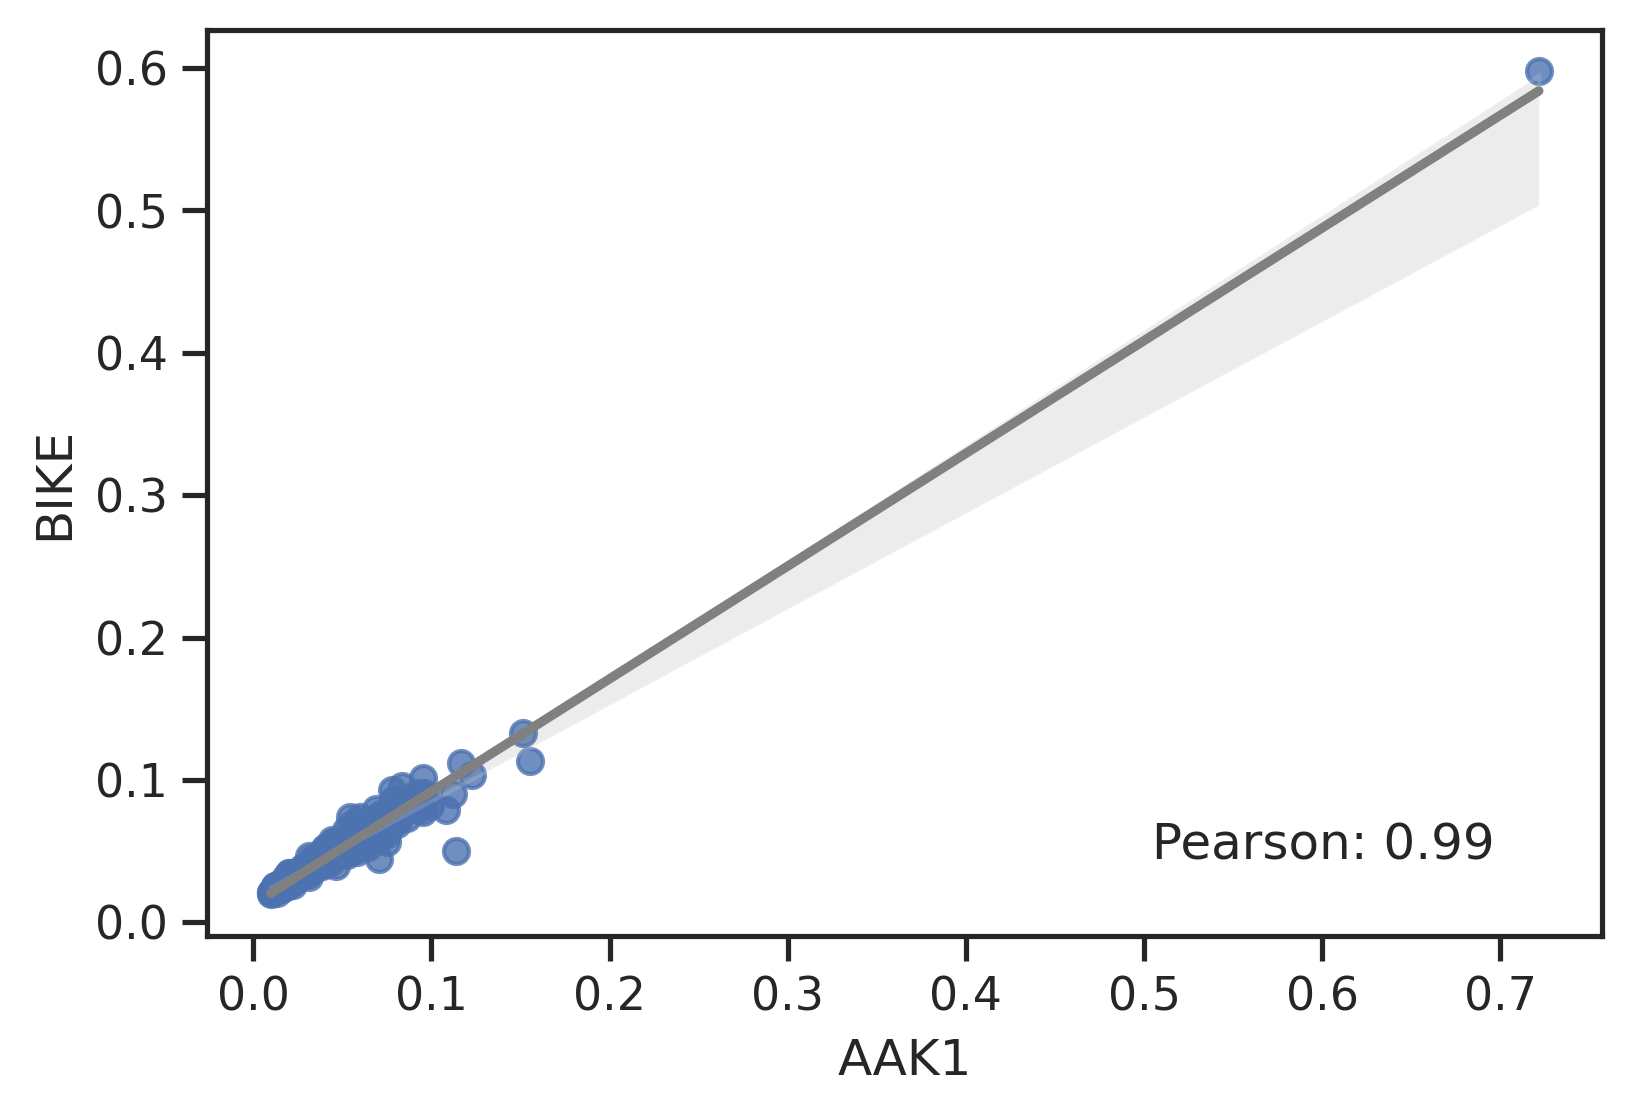

In [21]:
plot_corr(norm.loc['AAK1'],norm.loc['BIKE'])

In [22]:
#| export
def kinase_report(pred, kinase):
    
    pred_stack = pred.pivot(values = 'pred',index='kinase',columns = 'substrate').reset_index()

    label_stack = pred.pivot(values = 'label',index='kinase',columns = 'substrate').reset_index()
    
    raw_stack = Data.get_kinase_raw()
    
    print(f'Logo of {kinase}  from raw dataset')
    raw2logo(raw_stack, kinase)

    print(f'Logo of {kinase}  from reversed label')
    raw2logo(label_stack, kinase);

    print(f'Logo of {kinase}  based on prediction')
    raw2logo(pred_stack, kinase)

    
    print('correlation')
    plot_corr(pred.query(f'kinase == "{kinase}"').label,
          pred.query(f'kinase == "{kinase}"').pred, 
          method='pearson')

    
    print('colored by aa')
    sns.relplot(x = pred.query(f'kinase == "{kinase}"').label, 
            y = pred.query(f'kinase == "{kinase}"').pred, 
            hue = pred.query(f'kinase == "{kinase}"').aa, 
            palette = 'tab20' )
    plt.show()
    plt.close()
    
    return pred_stack, label_stack

In [23]:
#| hide
import nbdev; nbdev.nbdev_export()